First steps towards preparing the prediction models

In [32]:
data = pd.read_csv("../data/clean/clean_data.csv")

In [33]:

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data,test_size=0.20,stratify=data['treatment'],random_state=42 )

In [34]:
print(f'Train_data number : {train_data.shape}\n Test data number : {test_data.shape}')

Train_data number : (1007, 22)
 Test data number : (252, 22)


X/Y SPLIT

In [35]:
# Do the X/y split to seperate dependent from independent columns
X = data.drop('treatment', axis=1)
y = data['treatment']

Encode Categoricals

In [36]:
# Encode categorical columns to numerical
X = pd.get_dummies(X, drop_first=True)

Train/Test Split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Apply Standard Scaler

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

with open(r'../scaler/standard_scaler.pickle', 'wb') as file:
    pickle.dump(scaler, file)

Perform a gridsearch for RandomForestClassifier

In [39]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_leaf': [4,4],
    'min_samples_split': [4,4]
}

In [40]:
gs = GridSearchCV(estimator=RandomForestClassifier(),
                  param_grid=params, cv=5)
gs.fit(X_train_scaled, y_train)    

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_leaf': [4, 4],
                         'min_samples_split': [4, 4]})

In [41]:
gs.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 4, 'min_samples_split': 4}

In [42]:
y_train_pred = gs.predict(X_train_scaled)
y_test_pred  = gs.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)

0.5576452886966334

What does Cohen's kappa tell you?
Cohen's kappa is a metric often used to assess the agreement between two raters. It can also be used to assess the performance of a classification model.

In [43]:
with open(r'../model/random_forest.pickle', 'wb') as file:
    pickle.dump(gs.best_estimator_, file)

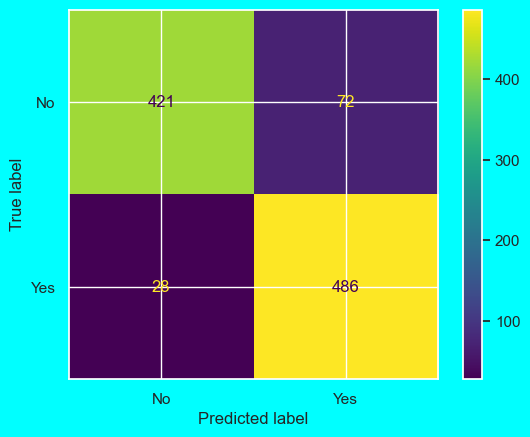

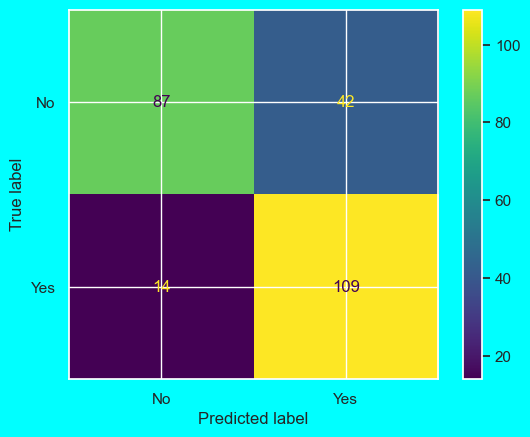

In [44]:
# Plot confusion matrix for train set prediction
cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

# Plot confusion matrix for test set prediction
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

In [45]:
results = cross_val_score(gs.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")

Average accuracy: 0.8103393921481701
Average accuracy: 0.7022745098039216


Perform a GridSearch for LogisticalRegression 

In [46]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'max_iter': [300]
}

gs2 = GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=5)
gs2.fit(X_train_scaled, y_train)

c:\Users\User\Desktop\python_script\Week_9\Final_project\venv\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\User\Desktop\python_script\Week_9\Final_project\venv\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\User\Desktop\python_script\Week_9\Final_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\User\Desktop

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'max_iter': [300],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                    'saga']})

In [47]:
# Show best parameters for LogisticRegression
gs2.best_params_

{'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}

In [48]:
# Store model
with open(r'../model/logistic_reg.pickle','wb') as file:
    pickle.dump(gs2.best_estimator_, file)

In [49]:
y_train_pred = gs2.predict(X_train_scaled)
y_test_pred  = gs2.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)
#better than RFC, but not by much

0.604296212549463

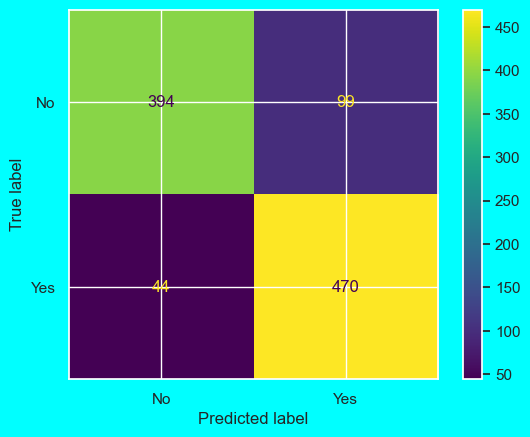

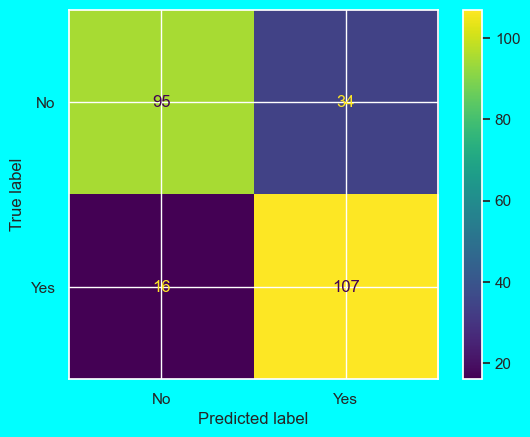

In [50]:
# Plot confusion matrix 
cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

In [51]:
results = cross_val_score(gs2.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs2.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")
#better than RFC

Average accuracy: 0.8351362001871829
Average accuracy: 0.7656470588235293


Perform a GridSearch for KNN-Classifier

In [52]:
params = {
    'n_neighbors': [3, 5, 8, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

gs3 = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=params, cv=5, verbose=3)
gs3.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.698 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.673 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.682 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.731 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=uniform;, score=0.692 total time=   0.0s
[CV 1/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.698 total time=   0.0s
[CV 2/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.678 total time=   0.0s
[CV 3/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.682 total time=   0.0s
[CV 4/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.731 total time=   0.0s
[CV 5/5] END algorithm=auto, n_neighbors=3, weights=distance;, score=0.692 total time=   0.0s
[CV

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 8, 10],
                         'weights': ['uniform', 'distance']},
             verbose=3)

In [53]:
y_train_pred = gs3.predict(X_train_scaled)
y_test_pred  = gs3.predict(X_test_scaled)
cohen_kappa_score(y_test, y_test_pred)
#lowest kappa so far

0.4245480494766889

In [54]:
results = cross_val_score(gs3.best_estimator_, X_train_scaled, y_train, cv=5)
print(f"Average accuracy: {results.mean()}")
results = cross_val_score(gs3.best_estimator_, X_test_scaled, y_test, cv=5)
print(f"Average accuracy: {results.mean()}")
#no surprise it's the lowest score again

Average accuracy: 0.716969607408502
Average accuracy: 0.6624313725490196


In [55]:
# Store model
with open(r'../model/knn.pickle','wb') as file:
    pickle.dump(gs3.best_estimator_, file)

So finally, a big part of our task has been completed.
The strongest model we have developed which can predict whether an employee seeks mental health treatment or not is the LogisticRegression model (gs2).
We will therefore use that model to extract the key features in figuring out whether or not an individual will choose to get mental-health assistance.

In [56]:
#gs2.fit(X,y)
#importance = gs2.best_estimator_.coef_[0]
#importance is a list so you can plot it. 
#feat_importances = pd.Series(importance)
#feat_importances.nlargest(10).plot(kind='barh',title = 'Feature Importance')

In [57]:
features = list(X_train.columns)

In [58]:
data1 = {'feature_names':features,'feature_importance': gs2.best_estimator_.coef_[0]}
featureimp_df = pd.DataFrame(data1)
featureimp_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

Text(0.5, 1.0, 'Key Features')

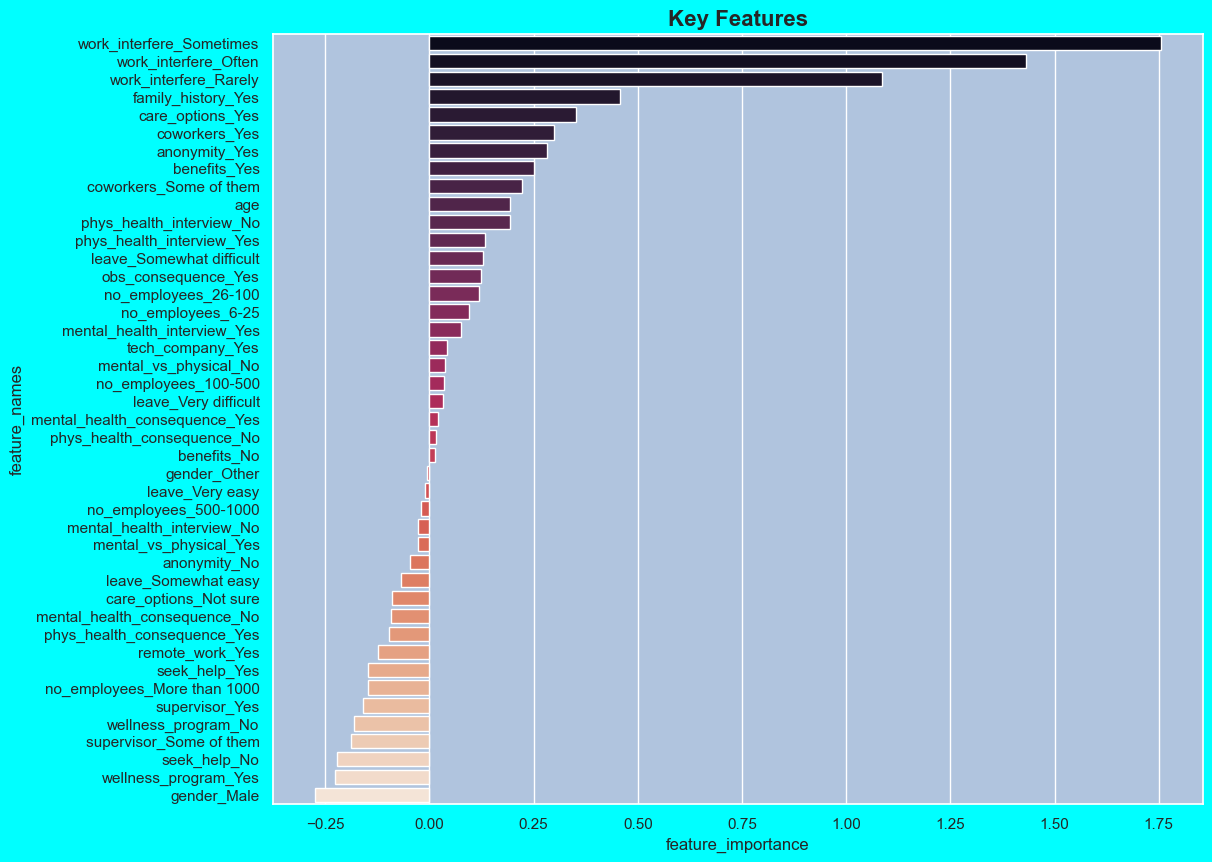

In [59]:
plt.figure(figsize=(12,10))
sns.set(rc={'axes.facecolor':'lightsteelblue', 'figure.facecolor':'cyan'})
sns.barplot(data = featureimp_df, x = 'feature_importance' , y = 'feature_names' , palette='rocket')
plt.title("Key Features", fontsize=16, fontweight="bold")

Conclusion:

- According to our results, work interference, no matter how often, is the largest contributer in predicting whether or not an employee would seek out treatment. This goes to show how important the perceived quality of their work is to the employee. If the participants sense that their mental-health gets in the way of doing their job, they are more willing to do something about it. 
- It seems that the whether or not an employee's mental health issues interfering with the work is the the best question to ask for an employer or trusted coworker in order to understand if the employee will seek treatment.
- Family history, trusted coworkers and care options(programs and benfits) provided by company are also influential for employees who want to get treatment.
- The remaining features seem to have a lesser contribution in understanding the employees treatment needs.
- Acknowledging some of these features early can possibly help support an individual who may be experiencing a mental health issues in order to help connect them with the appropriate company resources.
- Finally, preventing the rise of mental health issues in the first place for employees can reduce the amount of those seeking treatment. Prevention is key, and needs further study.